In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import nbins, rp_min, rp_max, rp_bins, rp_mids, H0, bin_file_comoving #, bin_file

from mock_clust import _compile_chisq, sig_tanh, sig_lin, _get_popt, _model_wp, _plot, _plot_mag_bins

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


<a class="anchor" id="outline"></a>

* [Get scatter parameters](#scatter)
* [Mock magnitudes](#mock_mags)
* [Clustering](#clust)


# Set parameters


In [33]:
band   = "MW1"
zrange = (0.4,0.5)

sham_scatter_key = "sham_lin3"

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

# abs_mag_ticks = np.arange(*abs_mag_range,0.5)

# n_mag_bins_clust   = 4
# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
# abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

lf_name = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func  = np.load(lf_name).item()
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
#=========== END HOUSEKEEPING ===========#


h = 0.6777


<a class="anchor" id="scatter"></a>

# Get optimized scatter parameters

[BACK TO TOP](#outline)

### Compute and save $\chi^2(\omega_{\rm p})$ in magnitude bins for $\sigma_{\rm SHAM}\times\sigma_{\rm LOS}$ grid

In [3]:
# def chisq_array(this_band, zrange, sham_tag="vpeak", sim_tag=None, pimax=150, h=H0/100, zmag_lim=20.7,
#                 cross="GXG", d="south", rp_use_range=None, rp_cen=rp_mids):
#     this_zsnap_tag = get_zsnap_tag( np.array(z_snaps)[ np.round(z_snaps,1)==zrange[0] ][0] )
#     assert(sim_tag != None)
    
#     sigma_const_array = np.round(np.arange(0.,1.01,0.01),2)
#     sigma_los_array   = np.arange(0,151,5)
# #     sigma_const_array = np.arange(0.0,0.61,0.01)
# #     sigma_los_array   = np.arange(0,121,5)

#     abs_mag_bin_tags = get_abs_mag_bin_tags(zrange[0], this_band, nbins=4)

#     this_abs_mag_lim = get_abs_mag_lim(zrange[0], this_band)
#     if this_band=="Mr":
#         this_abs_mag_lim_tag = get_Mr_tag(this_abs_mag_lim)
#     elif this_band=="Mz":
#         this_abs_mag_lim_tag = get_Mz_tag(this_abs_mag_lim)
#     elif this_band=="MW1":
#         this_abs_mag_lim_tag = get_MW1_tag(this_abs_mag_lim)

#     print(f"\n{this_band} < {this_abs_mag_lim} ({d})\n{zrange[0]} < zphot < {zrange[1]} ({this_zsnap_tag})")
    
#     rp_use_min, rp_use_max = rp_use_range
#     rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
#     print(rp_use_range, rp_use_tag)
        
#     save_path = f"{BASEDIR}/chisq/{rp_use_tag}"
#     Path( save_path ).mkdir(parents=True, exist_ok=True)
#     fname   = f"{d}_{sham_tag}_{this_abs_mag_lim_tag}_{this_zsnap_tag}.npy"
#     save_as = f"{save_path}/{fname}"

# #     if os.path.exists( save_as ):
# #         print(f"{save_as} found; loading...\n")
# #         out = np.load( save_as, allow_pickle=True).item()
# #     else:
#     out = {}
        
#     for abs_mag_bin_tag in abs_mag_bin_tags:
#         print(abs_mag_bin_tag)
#         chisq_matrix = np.zeros([len(sigma_const_array),len(sigma_los_array)])
#         summary = []

#         #-- data        
#         fpath_data    = f"{BASEDIR}/clustering/{zmag_tag}/{this_abs_mag_lim_tag}/{abs_mag_bin_tag}"
#         wp_fname_data = f"{fpath_data}/wp/{get_cat_tag(d, zrange)}_{cross}_pimax{int(pimax)}.txt"
        
#         if os.path.exists(wp_fname_data):
#             data = ascii.read(wp_fname_data)
#             rp_cen = h*data["rp_cen"]
#             wp     = h*data["wp"]
#             wp_err = h*data["wp_err"]

#             if (rp_use_min != None) & (rp_use_max != None):
#                 rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
#             elif (rp_use_min != None) & (rp_use_max==None):
#                 rp_use_idx = np.where(rp_cen > rp_use_min)[0]
#             elif (rp_use_min==None) & (rp_use_max != None):
#                 rp_use_idx = np.where(rp_cen < rp_use_max)[0]
#             else:
#                 rp_use_idx = np.arange(len(rp_cen))
                        
#             rp_pi_counts_fname = f"{fpath_data}/rp_pi_counts/{get_cat_tag(d, zrange)}_{cross}.npy"
#             cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
#             cov_inv = np.linalg.inv(cov)

#             for u,sigma_const in enumerate(sigma_const_array):
#                 sc = str(round(sigma_const,2)).replace(".","p")

#                 #-- model
#                 fpath_model = f"{BASEDIR}/clustering/mocks/{sim_tag}/{sham_tag}/{zmag_tag}/{this_abs_mag_lim_tag}/{abs_mag_bin_tag}/sigma_sham_const{sc}"
#                 fname_model = f"{this_zsnap_tag}_{d}_{cross}_pimax{int(pimax)}.npy"
#                 if os.path.exists(f"{fpath_model}/{fname_model}"):
#                     model_all_sigma_los = np.load(f"{fpath_model}/{fname_model}", allow_pickle=True).item()
                    
#                     for v,sigma_los in enumerate(sigma_los_array):
#                         los_key = f"sigma_los_{int(sigma_los)}"
#                         if los_key in model_all_sigma_los.keys():
#                             model  = model_all_sigma_los[los_key]
#                             wp_mod = h*model["wp"]
#                             chisq_terms = [ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ]
#                             chisq = np.sum(chisq_terms)
#                             chisq_matrix[u][v] = chisq
#                             summary.append( [chisq, sigma_const, sigma_los] )

#         summary = Table(data=np.array(summary), names=("chisq","sigma_const","sigma_los"))
#         out[ abs_mag_bin_tag ] = ( summary, chisq_matrix )
        
#     np.save(save_as, out, allow_pickle=True)
        
#     return out


In [4]:
# %%time

# import itertools as it

# #-- run the function
# # rp_use_range = (0.1,None)
# # out = chisq_array(band, (zmin,zmin+0.1), rp_use_range=rp_use_range, sim_tag=sim_tag)

# bands = ("Mz","MW1")
# zmins = (0.4,0.5,0.6)
# rp_minima = (0.1,0.2)
# # rp_minima = [1.0]

# combos = list(it.product(bands, zmins, rp_minima))

# print(combos)

# for i in range(len(combos)):
#     this_band, this_zmin, rp_use_min = combos[i]
#     print(f"\n{i+1} / {len(combos)}")
#     chisq_array(this_band, (this_zmin,this_zmin+0.1), rp_use_range=(rp_use_min,None), sim_tag=sim_tag)
    
# print("DONE!")
    

<a class="anchor" id="mock_mags"></a>

# Create mock with magnitudes

[BACK TO TOP](#outline)

### Load simulation snapshot

In [5]:
%%time

###############################
## Load simulation snapshot  ##
###############################

a     = snaps["scale"][snaps["redshift"]==zsim][0]
scale = f"{a:.4f}"
scale = scale.replace(".","p")

quiet = False
sham_tag_min = 125

snap_fname = f"{SIMDIR}/{sim_tag}/CATALOGS/{sham_tag}min{int(sham_tag_min)}/a{scale}.npy"

if os.path.exists( snap_fname ):
    if not quiet:
        print(f"Loading simulation shapshot (zsim = {zsim}; {sham_tag} > {sham_tag_min})...")
    halocat = Table( np.load(snap_fname) )
    
halocat.sort( sham_tag )

halocat = halocat[::-1]


Loading simulation shapshot (zsim = 0.42531; vpeak > 125)...
CPU times: user 47.5 s, sys: 9.68 s, total: 57.2 s
Wall time: 57.6 s


In [34]:
%%time

###################################################################
##  Infer halo number densities from target luminosity function  ##
###################################################################

halocat = halocat[np.log10(halocat["parent_mvir"]) >= 11.5]
sham_var = halocat[sham_tag]

#-- get value of nh = nh( sham_var ) for each value of sham_var

#-- halo number counts in bins of (log_)sham_var
H,_ = np.histogram( np.log10(sham_var), bins=sham_var_bins )

#-- halo abundance versus (min log_)sham_var
cdf_log_sham_var = np.max(np.cumsum(H))-np.cumsum(H)

#-- interpolation function for nh of (log_)sham_var
nh_of_log_sham_var = interpolate.interp1d(sham_var_cens, np.array(cdf_log_sham_var)/vol_sim, fill_value="extrapolate")

#-- inferred halo number densities for sham_var values
nh_inferred = nh_of_log_sham_var( np.log10(sham_var) )

cname = "nh_inferred"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(nh_inferred, name=cname) )


###################################################################################
##  Assign luminosities *without* scatter based on inferred halo number density  ##
###################################################################################

#-- get corresponding value of abs_mag for inferred nh values: abs_mag = abs_mag( ngal_eff=nh )
abs_mag_bins = lum_func_full["abs_mag_bins"]
ngal_eff     = lum_func_full["ng_eff"]

#-- interpolation function for abs_mag of ngal_eff
abs_mag_of_ngal_eff = interpolate.interp1d(ngal_eff, abs_mag_bins[::-1], fill_value="extrapolate")

nh_inferred = halocat["nh_inferred"]
abs_mag_inferred = abs_mag_of_ngal_eff( nh_inferred )

#-- add inferred magnitudes (with MONOTONIC Vcirc correspondence) to halo catalog
cname = f"{band}_no_scatter"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred, name=cname) )

halocat[f"{band}_no_scatter"][halocat[f"{band}_no_scatter"]==-np.inf] = np.inf



CPU times: user 5.12 s, sys: 1.85 s, total: 6.97 s
Wall time: 7.19 s


In [7]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# x = np.log10(halocat[sham_tag])[::1000]
# y = np.log10(halocat["nh_inferred"])[::1000]

# ax.scatter(x, y, s=1)

# ax.set_xlim(2.0,3.1)
# ax.set_ylim(-5.6,-1.5)

# ax.set_xlabel(r"log Vcirc")
# ax.set_ylabel(r"log halo number density (inferred)")

# plt.show()


CPU times: user 44.4 s, sys: 5.51 s, total: 50 s
Wall time: 50.8 s


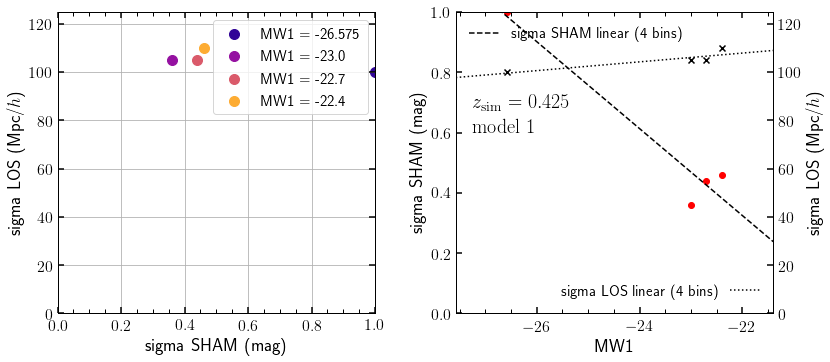

In [35]:
%%time

#################################################
##  Set functional type for mag_vpeak scatter  ##
#################################################

# for sham_scatter_key in ["sham_tanh","sham_lin3","sham_lin4"]:
N_chisq          = 1
rp_use_range     = (0.1,None)  # Mpc/h
mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}_chisq{N_chisq}"

rp_use_tag = get_rp_use_tag(rp_use_range)

nsig_clip  = 2.5


#################################################
##  Compute sigma array for mag-vpeak scatter  ##
#################################################

popt = _get_popt(band, zmin, N_chisq=N_chisq, rp_use_range=rp_use_range, sim_tag=sim_tag, quiet=False)

if "tanh" in sham_scatter_key:
    sigma_abs_mag_inferred = sig_tanh(halocat[f"{band}_no_scatter"], *popt[ sham_scatter_key ])
elif "lin" in sham_scatter_key:
    sigma_abs_mag_inferred = sig_lin(halocat[f"{band}_no_scatter"], *popt[ sham_scatter_key ])

#-- replace negative sigma values with zero if needed
sigma_abs_mag_inferred[np.where(sigma_abs_mag_inferred < 0)[0]] = 0

#-- add scatter to inferred magnitudes
abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"], sigma_abs_mag_inferred)


###########################################
##  Add scattered magnitudes to catalog  ##
###########################################

#-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
cname = f"{band}_scattered"
if cname in halocat.colnames:
    halocat.remove_column( cname )
halocat.add_column( Column(abs_mag_inferred_scattered, name=cname) )

halocat.sort( f"{band}_scattered" )

abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
abs_mag_inferred_sorted.sort()

if band in halocat.colnames:
    halocat.remove_column( band )
halocat.add_column( Column(abs_mag_inferred_sorted, name=band) )


##########################################
##  Flag (sub)halos with mock galaxies  ##
##########################################

#-- remove extra columns
cols = (f"{band}_scattered", "nh_inferred", "galaxy")
for c in cols:
    if c in halocat.colnames:
        halocat.remove_column(c)

#-- sort catalog by model magnitude       
halocat.sort( band )

#-- add column for galaxy flag
c = "galaxy"
if c in halocat.colnames:
    halocat.remove_column(c)
halocat.add_column(Column(np.zeros(len(halocat),dtype=bool), name=c))

#-- number of (sub)halos to select based on number density from data
Nhalo_select = int(np.max(lum_func["ng_eff"])*vol_sim)

#-- flag halos with galaxies
halocat["galaxy"][:Nhalo_select] = True

#     #################################
#     ##  Save mock with magnitudes  ##
#     #################################

#     fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}.npy"
#     print(fname)

#     np.save(fname, halocat)

#     this_zsim      = zsim
#     this_zsnap_tag = zsnap_tag

#     this_abs_mag_lim_tag = abs_mag_lim_tag
#     this_zmin, this_zmax = zrange

#     mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}_chisq{N_chisq}"

#     for los_scatter_key in ("los_lin3","los_lin4","los_binned3","los_binned4"):
#         print(f"N_chisq      = {N_chisq}")
#         print(f"rp_use_range = {rp_use_range}")
#         print(f"rp_use_tag   = {rp_use_tag}")
#         print(f"sham_scatter_key = {sham_scatter_key}")
#         print(f"los_scatter_key  = {los_scatter_key}")

#         kwargs = dict(DS=1, n_iter=1, boxsize=get_boxsize(sim_tag), BASEDIR=BASEDIR, cat=halocat, sim_tag=sim_tag,
#                       rp_use_range     = rp_use_range,
#                       N_chisq          = N_chisq,
#                       sham_scatter_key = sham_scatter_key,
#                       los_scatter_key  = los_scatter_key,
#                       quiet            = False,
#                       save             = True,
#                       bin_file         = bin_file_comoving,
#                      )

#         _plot(band, zmin, **kwargs)

#         _plot_mag_bins(band, zmin, **kwargs)



<a class="anchor" id="clust"></a>

# Clustering

[BACK TO TOP](#outline)


In [9]:
# def _tolp(band, zmin,
#           cat                = None,
#           sham_scatter_key   = None,
#           los_scatter_key    = None,
#           N_chisq            = 1,
#           DS                 = 1,
#           n_iter             = 1,
#           boxsize            = None,
#           BASEDIR            = None,
#           return_model_error = False,
#           h                  = H0/100,
#           d                  = "south",
#           pimax              = 150.,
#           zmag_lim           = 20.7,
#           cross              = "GXG",
#           quiet              = True,
#           save               = True,
#           rp_use_range       = None,
#           popt               = None,
#           bin_file           = None,
#           sim_tag            = None,
#          ):
#     assert(sim_tag != None)
#     zmag_tag = get_zmag_tag(zmag_lim)
#     MW1lim   = get_abs_mag_lim(zmin,"MW1")
#     Mrlim    = get_abs_mag_lim(zmin,"Mr")
#     Mzlim    = get_abs_mag_lim(zmin,"Mz")
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag(MW1lim)
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag(Mrlim)
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag(Mzlim)
#     else:
#         raise Exception()

#     zmax = zmin + 0.1
#     # print(f"{band}\t({zmin:.1f},{zmax:.1f})\n")
    
#     cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
#     if band=="MW1":
#         abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
#     elif band=="Mr":
#         abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
#     elif band=="Mz":
#         abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
#     else:
#         raise Exception()

#     #-- data
#     wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
#     fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
#     if not os.path.exists(f"{fpath}/{wp_fname}"):
#         fpath = f"{BASEDIR}/clustering/{zmag_tag}/v0.2/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
        
#     data = ascii.read(f"{fpath}/{wp_fname}")
#     rp_cen = h*data["rp_cen"]
#     wp     = h*data["wp"]
#     wp_err = h*np.sqrt(data["wp_err"])

#     rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
#     cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
#     cov_inv = np.linalg.inv(cov)
    
#     kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
#                            return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag,
#                            sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key, sim_tag=sim_tag,
#                            N_chisq=N_chisq, rp_use_range=rp_use_range, quiet=quiet, bin_file=bin_file)
#     models = {}
#     sham_scatter_tag = sham_scatter_key.replace("_","-")
#     if los_scatter_key != None:
#         fig_scatter_tag  = f"{sham_scatter_tag}_chisq{N_chisq}_{los_scatter_key.replace('_','-')}"
#     else:
#         fig_scatter_tag  = f"{sham_scatter_tag}_chisq{N_chisq}_los-None"

#     args   = (band, zmin)
#     wp_mod = _model_wp(*args, **kwargs_model_wp)
#     models[sham_scatter_tag] = wp_mod
        
#     rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
        
#     rp_use_min, rp_use_max = rp_use_range
#     if (rp_use_min != None) & (rp_use_max != None):
#         rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
#     elif (rp_use_min != None) & (rp_use_max==None):
#         rp_use_idx = np.where(rp_cen > rp_use_min)[0]
#     elif (rp_use_min==None) & (rp_use_max != None):
#         rp_use_idx = np.where(rp_cen < rp_use_max)[0]
#     else:
#         rp_use_idx = np.arange(len(rp_cen))

#     N_rp  = len(rp_use_idx)
#     N_dof = 3 if "tanh" in sham_scatter_tag else 2

#     #-- make the figure
#     fig, ax = plt.subplots(1, 1, figsize=(8,7))

#     ax.set_xlim(0.02, 50)
#     ax.set_ylim(1, 6e3)

#     ax.tick_params(axis="both", which="major", labelsize=24)
#     ax.set_xlabel(fig_labels["rp"], fontsize=24)
#     ax.set_ylabel(fig_labels["wp"], fontsize=24)

#     mag_label = r" $(M_{W1} <\ $" if (band=="MW1") else f" $(M_{band[1:]} <\ $"
#     abs_mag_lim = get_abs_mag_lim(zmin, band)
#     data_label = r"${\rm data}$" + mag_label + f"${abs_mag_lim})$"

#     #-- plot data points
#     ax.errorbar(rp_cen, wp, yerr=wp_err, label=data_label, marker="o", ms=5, color="k", linestyle="")

#     #-- plot models
#     colors = get_colors(3)
#     lines  = ("-", "dashdot", "--", ":")
    
#     for idx,k in enumerate(models.keys()):
#         wp_mod = h*models[k]
#         chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
#         chisq_dof = chisq/(N_rp - N_dof)
#         chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
#         model_label = r"${\rm model}$" + f" $(${rp_use_label}$;\ ${chisq_label}$)$"
#         ax.plot(rp_cen, wp_mod, color=colors[idx], label=model_label, lw=2, ls=lines[idx])

#     zphot_label = f"${zmin}\ $" + r"$ < z_{\rm phot} < $" + f"$\ {zmax}$"
#     ax.text(get_corners(ax, log=True, margin=0.05)["upper_left"][0], 110, zphot_label, ha="left", va="top", fontsize=24)

#     ax.legend(fontsize=20, loc=2, handletextpad=0.5)
#     ax.loglog()
#     if rp_use_min != None:
#         ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
#     if rp_use_max != None:
#         ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

#     plt.tight_layout()

#     fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
#     fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}_wp-vs-rp.png"
#     if not save:
#         print(f"{fpath}/{fname}")
#     elif save:
#         print(f"\n{now()} Saving {fpath}/{fname}...")
#         plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
#     return


In [31]:
def _get_abs_mag_bin_label(tag):
    if "Mz" in tag[:3]:
        band = r"$M_z$"
        tag = tag[2:]
    elif "Mr" in tag[:3]:
        band = r"$M_r$"
        tag = tag[2:]
    elif "MW1" in tag[:3]:
        band = r"$M_{W1}$"
        tag = tag[3:]
    else:
        raise Exception()

    mag1, mag2 = tag.replace("p",".").split("-")
    
    if mag1[0]=="n": mag1 = -float(mag1[1:])
    else: mag1 = float(mag1)
    if mag2[0]=="n": mag2 = -float(mag2[1:])
    else: mag2 = float(mag2)
    
    if mag1 > mag1:
        mag_max = mag1
        mag_min = mag2
    else:
        mag_max = mag2
        mag_min = mag1
    
    if (mag_max - mag_min) > 5:
        label = band + f" $< {mag_max:.2f}$"
    elif (mag_max - mag_min) < -5:
        label = f"${mag_min:.2f} <$ " + band
    else:
        label = f"${mag_min:.2f} <$ " + band + f" $< {mag_max:.2f}$"

    return label


def _tolp_mag_bins(band, zmin,
                   cat                = None,
                   sham_scatter_key   = None,
                   los_scatter_key    = None,
                   N_chisq            = 1,
                   DS                 = 1,
                   n_iter             = 1,
                   boxsize            = None,
                   BASEDIR            = None,
                   return_model_error = False,
                   n_mag_bins_clust   = 4,
                   h                  = H0/100,
                   d                  = "south",
                   pimax              = 150.,
                   zmag_lim           = 20.7,
                   cross              = "GXG",
                   quiet              = False,
                   save               = True,
                   rp_use_range       = None,
                   popt               = None,
                   bin_file           = None,
                   sim_tag            = None,
                  ):
    assert(sim_tag != None)
    zmag_tag = get_zmag_tag(zmag_lim)
    MW1lim   = get_abs_mag_lim(zmin,"MW1")
    Mrlim    = get_abs_mag_lim(zmin,"Mr")
    Mzlim    = get_abs_mag_lim(zmin,"Mz")
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(MW1lim)
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag(Mrlim)
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(Mzlim)
    else:
        raise Exception()

    zmax = zmin + 0.1
    
    cat_tag = get_cat_tag(d,(zmin,zmin+0.1))
    if band=="MW1":
        abs_mag_lim_tag = get_MW1_tag( get_abs_mag_lim(zmin,"MW1") )
    elif band=="Mr":
        abs_mag_lim_tag = get_Mr_tag( get_abs_mag_lim(zmin,"Mr") )
    elif band=="Mz":
        abs_mag_lim_tag = get_Mz_tag( get_abs_mag_lim(zmin,"Mz") )
    else:
        raise Exception()
        
    abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
    abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

    sham_scatter_tag = sham_scatter_key.replace("_","-")
    sham_scatter_tag = sham_scatter_key.replace("_","-")
    if los_scatter_key != None:
        fig_scatter_tag  = f"{sham_scatter_tag}_chisq{N_chisq}_{los_scatter_key.replace('_','-')}"
    else:
        fig_scatter_tag  = f"{sham_scatter_tag}_chisq{N_chisq}_los-None"
    args = (band, zmin)
    kwargs_model_wp = dict(DS=DS, n_iter=n_iter, boxsize=boxsize, BASEDIR=BASEDIR, cat_tag=cat_tag, cat=cat,
                           return_model_error=return_model_error, abs_mag_lim_tag=abs_mag_lim_tag, bin_file=bin_file,
                           abs_mag_bin_tags=abs_mag_bin_tags, rp_use_range=rp_use_range, quiet=quiet, sim_tag=sim_tag,
                           sham_scatter_key=sham_scatter_key, los_scatter_key=los_scatter_key, N_chisq=N_chisq)
    models = _model_wp(*args, **kwargs_model_wp)
    
    rp_use_tag, rp_use_label = get_rp_use_tag(rp_use_range, return_tag=True, return_label=True)
    
    rp_cen = h*rp_mids
    rp_use_min, rp_use_max = rp_use_range
    if (rp_use_min != None) & (rp_use_max != None):
        rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
    elif (rp_use_min != None) & (rp_use_max==None):
        rp_use_idx = np.where(rp_cen > rp_use_min)[0]
    elif (rp_use_min==None) & (rp_use_max != None):
        rp_use_idx = np.where(rp_cen < rp_use_max)[0]
    else:
        rp_use_idx = np.arange(len(rp_cen))

    N_rp  = len(rp_use_idx)
    N_dof = 3 if "tanh" in sham_scatter_tag else 2

    #-- make the figure
    fig, ax = plt.subplots(1, 1, figsize=(7,7))

    ax.set_xlim(0.02, 50)
    ax.set_ylim(1, 2e3)
    ax.tick_params(axis="both", which="major", labelsize=24)
    ax.set_xlabel(fig_labels["rp"], fontsize=24)
    ax.set_ylabel(fig_labels["wp"], fontsize=24)
    
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"
    colors = get_colors(len(abs_mag_bin_tags))
    lines  = ("-", "dashdot", "--", ":", "-")

    for idx,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
        fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
        
        data = ascii.read(f"{fpath}/{wp_fname}")
        rp_cen = h*data["rp_cen"]
        wp     = h*data["wp"]
        wp_err = h*np.sqrt(data["wp_err"])

        rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
        cov = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
        cov_inv = np.linalg.inv(cov)

        #-- plot data points
        mag_label = _get_abs_mag_bin_label(abs_mag_bin_tag)
        ax.errorbar(rp_cen, wp, yerr=wp_err, label=mag_label, marker="o", ms=6, alpha=0.8, color=colors[idx], linestyle="")

        #-- plot models    
        wp_mod = h*models[abs_mag_bin_tag]
        # chisq  = np.sum([ [ (wp - wp_mod)[i]*cov_inv[i,j]*(wp - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
        # chisq_dof = chisq/(N_rp - N_dof)
        # chisq_label = r"$\chi^2_{\nu}=\ $" + f"${int(chisq_dof)}$"
        ax.plot(rp_cen, wp_mod, color=colors[idx], lw=1.5)#, ls=lines[idx])#, label=chisq_label)

    zphot_label = f"${zmin}\ $" + r"$ < z_{\rm phot} < $" + f"$\ {zmax}$" + "\n" + r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$"# + f"\n{rp_use_label}"
    ax.text(*get_corners(ax, log=True, margin=0.05)["upper_right"], zphot_label, ha="right", va="top", fontsize=28)

    ax.legend(fontsize=22, loc=3, handletextpad=0.5, labelspacing=0.25, numpoints=2, handlelength=1.5, borderpad=0.05)
    ax.loglog()

    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)

    plt.tight_layout()

    fpath = f"{BASEDIR}/figures/wp_model-vs-data/{band}/{cat_tag[:-6]}"
    fname = f"{abs_mag_lim_tag}_{fig_scatter_tag}_{rp_use_tag}_mag-bins_SLIDES.png"
    if not save:
        print(f"{fpath}/{fname}")
    elif save:
        print(f"\n{now()} Saving {fpath}/{fname}...")
        plt.savefig(f"{fpath}/{fname}", bbox_inches="tight", pad_inches=0.1, dpi=200)
    return


N_chisq      = 1
rp_use_range = (0.1, None)
rp_use_tag   = rpmin0p1Mpch
sham_scatter_key = sham_lin3
los_scatter_key  = los_lin3

[17:54:25] Saving /Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/MW1/z0p40-0p50/MW1limn22p25_sham-lin3_chisq1_los-lin3_rpmin0p1Mpch_mag-bins_SLIDES.png...
N_chisq      = 1
rp_use_range = (0.1, None)
rp_use_tag   = rpmin0p1Mpch
sham_scatter_key = sham_lin3
los_scatter_key  = los_lin4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/table.py:2653: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  result = self.as_array() == other



[17:54:51] Saving /Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/MW1/z0p40-0p50/MW1limn22p25_sham-lin3_chisq1_los-lin4_rpmin0p1Mpch_mag-bins_SLIDES.png...
N_chisq      = 1
rp_use_range = (0.1, None)
rp_use_tag   = rpmin0p1Mpch
sham_scatter_key = sham_lin3
los_scatter_key  = los_binned3

[17:55:17] Saving /Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/MW1/z0p40-0p50/MW1limn22p25_sham-lin3_chisq1_los-binned3_rpmin0p1Mpch_mag-bins_SLIDES.png...
N_chisq      = 1
rp_use_range = (0.1, None)
rp_use_tag   = rpmin0p1Mpch
sham_scatter_key = sham_lin3
los_scatter_key  = los_binned4

[17:55:42] Saving /Users/aberti/Desktop/research/desi_lrg_sham/figures/wp_model-vs-data/MW1/z0p40-0p50/MW1limn22p25_sham-lin3_chisq1_los-binned4_rpmin0p1Mpch_mag-bins_SLIDES.png...
CPU times: user 1min 43s, sys: 8.59 s, total: 1min 51s
Wall time: 1min 41s


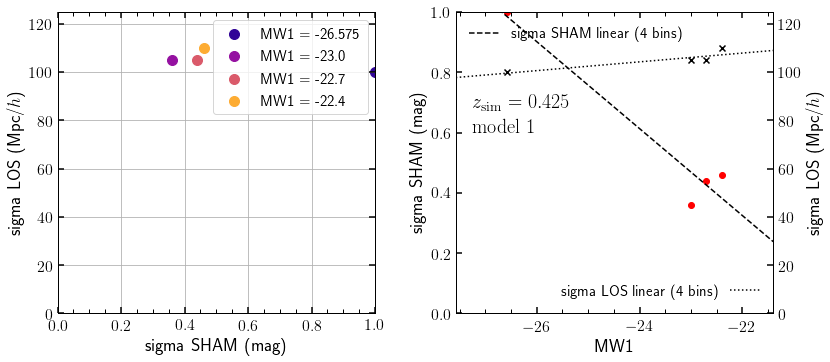

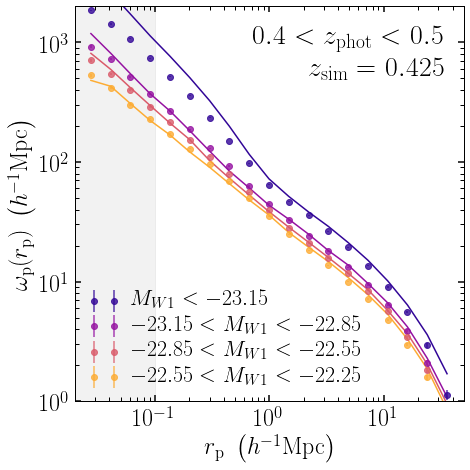

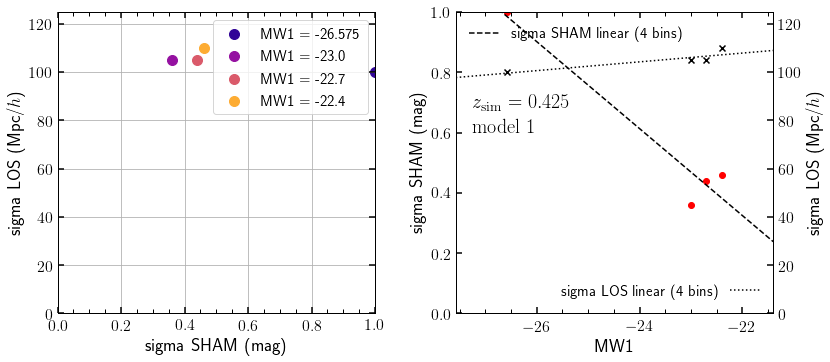

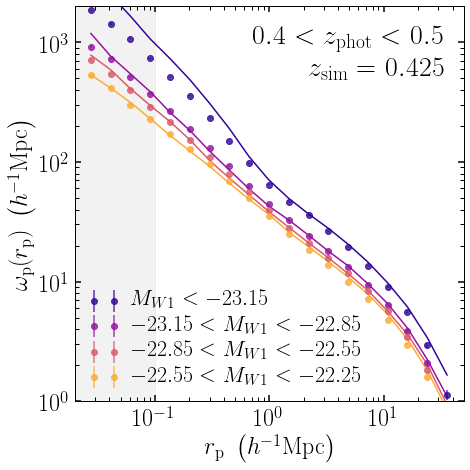

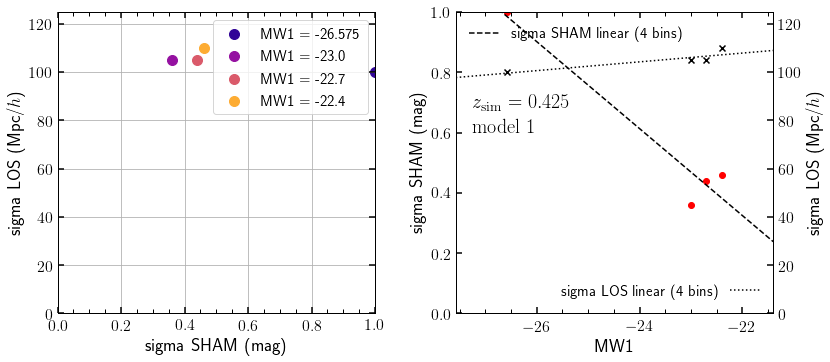

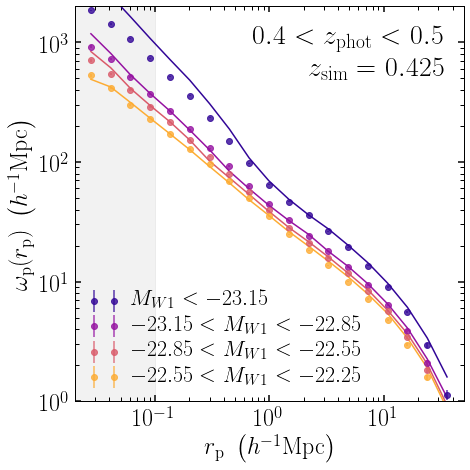

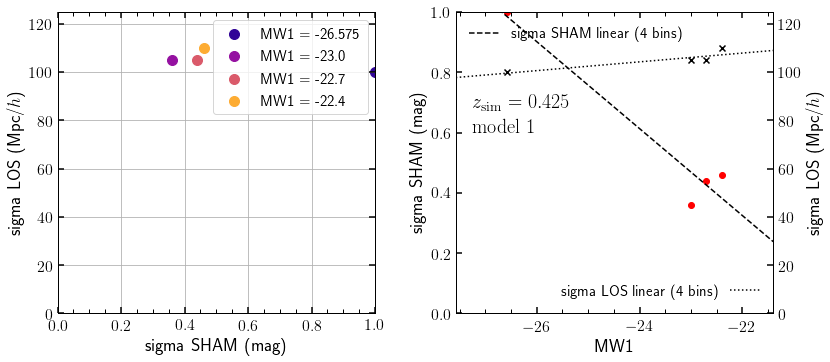

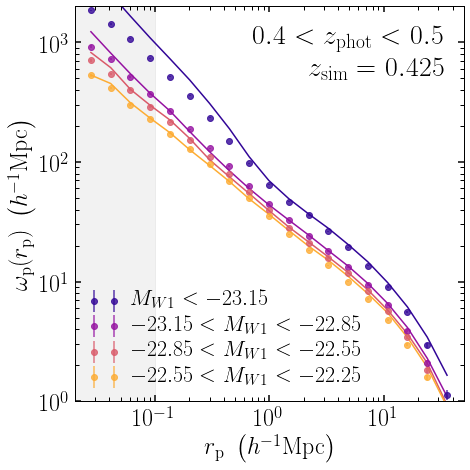

In [36]:
%%time

this_band   = band
this_zrange = zrange

this_zsim      = zsim
this_zsnap_tag = zsnap_tag

this_abs_mag_lim_tag = abs_mag_lim_tag
this_zmin, this_zmax = this_zrange

mock_scatter_tag = f"{sham_scatter_key.replace('_','-')}_chisq{N_chisq}"

for los_scatter_key in ("los_lin3","los_lin4","los_binned3","los_binned4"):
    print(f"N_chisq      = {N_chisq}")
    print(f"rp_use_range = {rp_use_range}")
    print(f"rp_use_tag   = {rp_use_tag}")
    print(f"sham_scatter_key = {sham_scatter_key}")
    print(f"los_scatter_key  = {los_scatter_key}")

    kwargs = dict(DS=1, n_iter=1, boxsize=get_boxsize(sim_tag), BASEDIR=BASEDIR, cat=halocat, sim_tag=sim_tag,
                  rp_use_range     = rp_use_range,
                  N_chisq          = N_chisq,
                  sham_scatter_key = sham_scatter_key,
                  los_scatter_key  = los_scatter_key,
                  quiet            = False,
                  save             = True,
                  bin_file         = bin_file_comoving,
                 )

    _tolp_mag_bins(this_band, this_zmin, **kwargs)


In [11]:
# %%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}"

# #-- galaxies with magnitudes, colors, LRG flags
# galcat_fname = f"{f}_galcat_LRG-flagged.npy"

# #-- galaxies with magnitudes
# galcat_fname = f"{f}.npy"

# print(galcat_fname)

# cat = Table(np.load(galcat_fname))
